In [1]:
from vulnerable_populations.pipeline import Granularity

granularity = Granularity.STATE_LEVEL

In [2]:
csbh_data = catalog.load(f"int_csbh_{granularity.value}_data")
csbh_data

2020-06-14 01:56:30,918 - kedro.io.data_catalog - INFO - Loading data from `int_csbh_state_level_data` (ParquetDataSet)...


,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,NaN,NaN,Wyoming,WY,577737,18,1009,3,174,...,0.372,0.022,0.008,0.009,0.098,0.001,0.841,0.000,0.021,0.137
1,All,NaN,NaN,Alabama,AL,4887871,755,22845,15,467,...,0.511,0.005,0.013,0.264,0.042,0.000,0.657,0.002,0.017,0.324
2,All,NaN,NaN,Alaska,AK,737438,11,609,1,82,...,0.408,0.140,0.062,0.031,0.069,0.012,0.610,0.002,0.074,0.314
3,All,NaN,NaN,Arizona,AZ,7171646,1135,31267,15,435,...,0.485,0.039,0.032,0.041,0.311,0.002,0.551,0.001,0.022,0.426
4,All,NaN,NaN,Arkansas,AR,3013825,171,10816,5,358,...,0.636,0.006,0.015,0.153,0.073,0.003,0.727,0.002,0.022,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Medicare FFS,NaN,NaN,Vermont,VT,626299,55,1110,8,177,...,0.387,0.003,0.017,0.012,0.019,0.000,0.930,0.001,0.018,0.051
98,Medicare FFS,NaN,NaN,Virginia,VA,8517685,1520,52647,17,618,...,0.426,0.002,0.063,0.188,0.092,0.001,0.622,0.003,0.030,0.345
99,Medicare FFS,NaN,NaN,Washington,WA,7535591,1194,24779,15,328,...,0.441,0.011,0.083,0.036,0.125,0.006,0.691,0.002,0.047,0.260
100,Medicare FFS,NaN,NaN,West Virginia,WV,1805832,86,2217,4,122,...,0.492,0.002,0.008,0.036,0.015,0.000,0.921,0.002,0.016,0.061


In [3]:
master = csbh_data.loc[csbh_data["Insurance Type (Relevant for Clinical Data from Claims Only)"] == "All"]
master

,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,NaN,NaN,Wyoming,WY,577737,18,1009,3,174,...,0.372,0.022,0.008,0.009,0.098,0.001,0.841,0.000,0.021,0.137
1,All,NaN,NaN,Alabama,AL,4887871,755,22845,15,467,...,0.511,0.005,0.013,0.264,0.042,0.000,0.657,0.002,0.017,0.324
2,All,NaN,NaN,Alaska,AK,737438,11,609,1,82,...,0.408,0.140,0.062,0.031,0.069,0.012,0.610,0.002,0.074,0.314
3,All,NaN,NaN,Arizona,AZ,7171646,1135,31267,15,435,...,0.485,0.039,0.032,0.041,0.311,0.002,0.551,0.001,0.022,0.426
4,All,NaN,NaN,Arkansas,AR,3013825,171,10816,5,358,...,0.636,0.006,0.015,0.153,0.073,0.003,0.727,0.002,0.022,0.250
5,All,NaN,NaN,California,CA,39557045,4934,143377,12,362,...,0.580,0.004,0.141,0.055,0.389,0.004,0.375,0.002,0.030,0.592
6,All,NaN,NaN,Colorado,CO,5695564,1582,28632,27,502,...,0.425,0.005,0.031,0.039,0.214,0.001,0.683,0.002,0.024,0.291
7,All,NaN,NaN,Connecticut,CT,3572665,4146,44461,116,1244,...,0.377,0.001,0.044,0.098,0.157,0.000,0.675,0.003,0.021,0.301
8,All,NaN,NaN,Delaware,DE,967171,414,10106,42,1044,...,0.378,0.003,0.038,0.216,0.091,0.000,0.627,0.002,0.023,0.348
9,All,NaN,NaN,District of Columbia,DC,702455,502,9589,71,1365,...,0.751,0.002,0.038,0.461,0.109,0.000,0.362,0.004,0.023,0.611


In [4]:
from enum import Enum


class Target(Enum):
    DEATHS = "Deaths from Covid 19 Per 100K Population"
    CASES = "Cases of Covid 19 Per 100K Population"

In [5]:
# X = master.loc[
#     :,
#     [
#         "Population Density",
#         "American Indian or Alaska Native",
#         "Asian",
#         "Black or African American",
#         "Hispanic",
#         "Native Hawaiian or Other Pacific Islander",
#         "Non-Hispanic White",
#     ]
# ]
X = master.loc[:, "Age 60+":]
y = master[Target.CASES.value]

In [6]:
(y > 0).mean(skipna=False)

1.0

In [7]:
(csbh_data
 .loc[csbh_data["Insurance Type (Relevant for Clinical Data from Claims Only)"] == "All"]
 ["Deaths from Covid 19 Per 100K Population"] > 0).sum()

51

In [8]:
import pandas as pd

with pd.option_context("display.max_rows", None):
    display(csbh_data.dtypes)

Insurance Type (Relevant for Clinical Data from Claims Only)     object
FIPS County Code                                                float64
County                                                          float64
State                                                            object
State Code                                                       object
Population                                                        int64
Deaths from COVID-19                                              int64
Cases of COVID-19                                                 int64
Deaths from Covid 19 Per 100K Population                          int64
Cases of Covid 19 Per 100K Population                             int64
Age 60+                                                         float64
Age 70+                                                         float64
Age 80+                                                         float64
Asthma                                                          

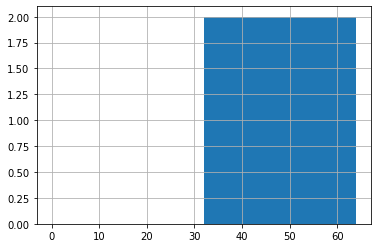

In [9]:
y.hist(bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 2, 4, 8, 16, 32, 64])

In [10]:
len(y)

51

In [11]:
len(y.to_numpy().nonzero()[0])

51

In [12]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model, data=X)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


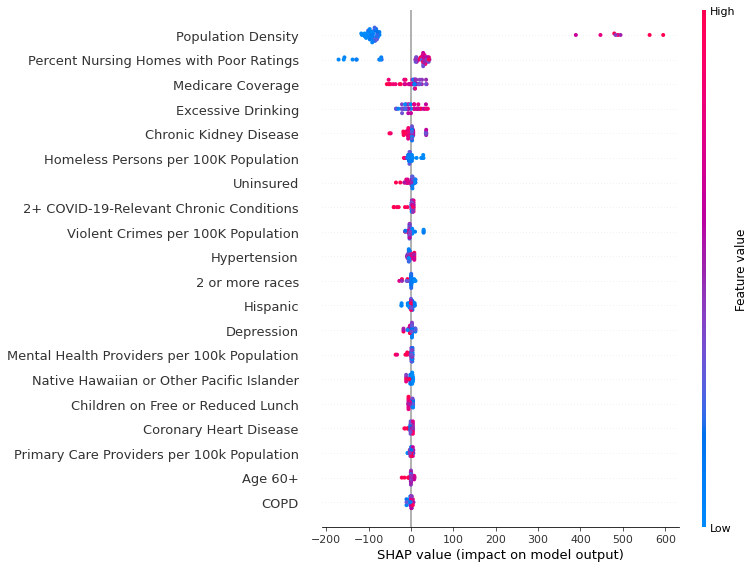

In [13]:
shap.summary_plot(shap_values, X)

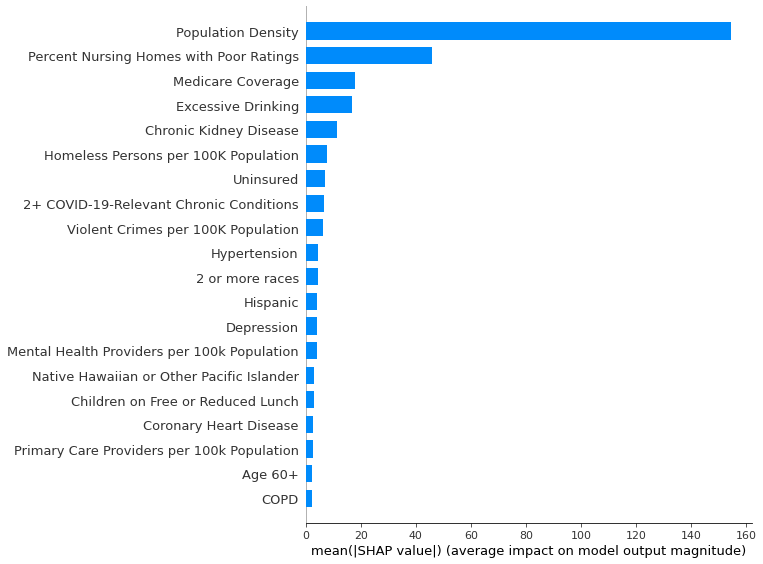

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [15]:
X

,Age 60+,Age 70+,Age 80+,Asthma,Cancer,Chronic Kidney Disease,Chronic Liver Disease,COPD,Coronary Heart Disease,Diabetes,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,0.220,0.097,0.034,0.043,0.019,0.029,0.007,0.030,0.041,0.050,...,0.372,0.022,0.008,0.009,0.098,0.001,0.841,0.000,0.021,0.137
1,0.225,0.107,0.037,0.049,0.020,0.051,0.009,0.037,0.060,0.079,...,0.511,0.005,0.013,0.264,0.042,0.000,0.657,0.002,0.017,0.324
2,0.166,0.062,0.018,0.034,0.016,0.030,0.008,0.019,0.030,0.043,...,0.408,0.140,0.062,0.031,0.069,0.012,0.610,0.002,0.074,0.314
3,0.226,0.113,0.038,0.047,0.021,0.048,0.011,0.027,0.045,0.063,...,0.485,0.039,0.032,0.041,0.311,0.002,0.551,0.001,0.022,0.426
4,0.224,0.109,0.038,0.049,0.021,0.046,0.009,0.039,0.066,0.076,...,0.636,0.006,0.015,0.153,0.073,0.003,0.727,0.002,0.022,0.250
5,0.192,0.090,0.034,0.038,0.016,0.042,0.012,0.019,0.035,0.062,...,0.580,0.004,0.141,0.055,0.389,0.004,0.375,0.002,0.030,0.592
6,0.194,0.085,0.029,0.032,0.016,0.030,0.009,0.020,0.028,0.039,...,0.425,0.005,0.031,0.039,0.214,0.001,0.683,0.002,0.024,0.291
7,0.230,0.112,0.045,0.048,0.022,0.038,0.009,0.023,0.040,0.061,...,0.377,0.001,0.044,0.098,0.157,0.000,0.675,0.003,0.021,0.301
8,0.241,0.116,0.039,0.058,0.027,0.053,0.012,0.031,0.056,0.077,...,0.378,0.003,0.038,0.216,0.091,0.000,0.627,0.002,0.023,0.348
9,0.168,0.081,0.030,0.046,0.016,0.039,0.009,0.016,0.029,0.060,...,0.751,0.002,0.038,0.461,0.109,0.000,0.362,0.004,0.023,0.611


In [16]:
y

0      174
1      467
2       82
3      435
4      358
5      362
6      502
7     1244
8     1044
9     1365
10     324
11     522
12      48
13     185
14    1025
15     579
16     727
17     371
18     267
19     954
20     199
21     996
22    1516
23     654
24     522
25     618
26     256
27      52
28     845
29     345
30     384
31    1861
32     447
33    1949
34     381
35     392
36     342
37     193
38     124
39     639
40    1500
41     323
42     642
43     418
44     287
45     419
46     177
47     618
48     328
49     122
50     377
Name: Cases of Covid 19 Per 100K Population, dtype: int64

In [17]:
shap_values

array([[ -0.1150568 ,   0.        ,   0.79809083, ...,   0.        ,
          0.77161027,  -0.41069558],
       [  0.33636525,   0.        ,   2.93108365, ...,   0.        ,
          5.02164024,   0.1961481 ],
       [ -0.27016722,   0.        ,   0.79809083, ...,   0.        ,
         -7.96736064,   0.19375951],
       ...,
       [  0.55448669,   0.        ,   0.19002163, ...,   0.        ,
        -27.30333508,   0.1961481 ],
       [-15.25015682,   0.        ,  -1.02136623, ...,   0.        ,
          4.03597588,  -0.16167671],
       [  7.76958397,   0.        ,  -1.61518387, ...,   0.        ,
          0.36147263,  -0.89856325]])